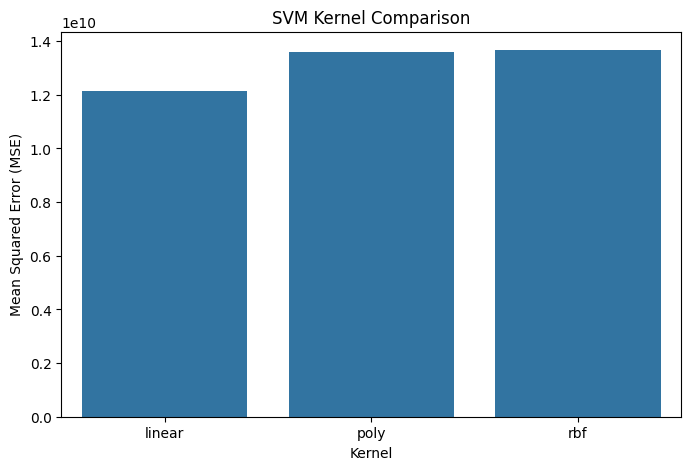

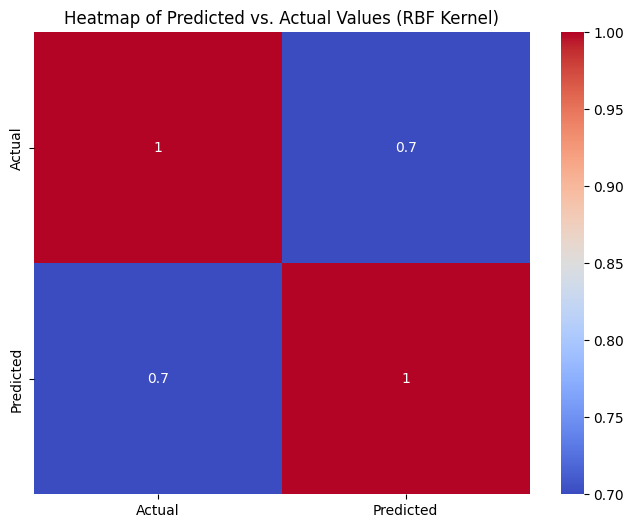

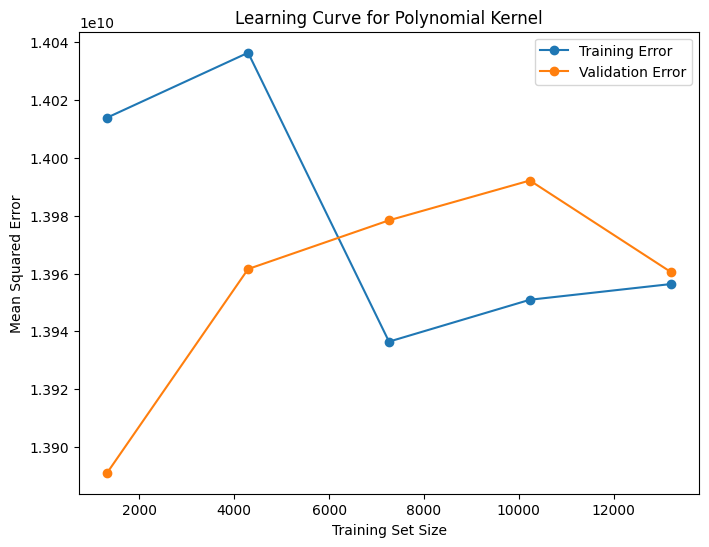

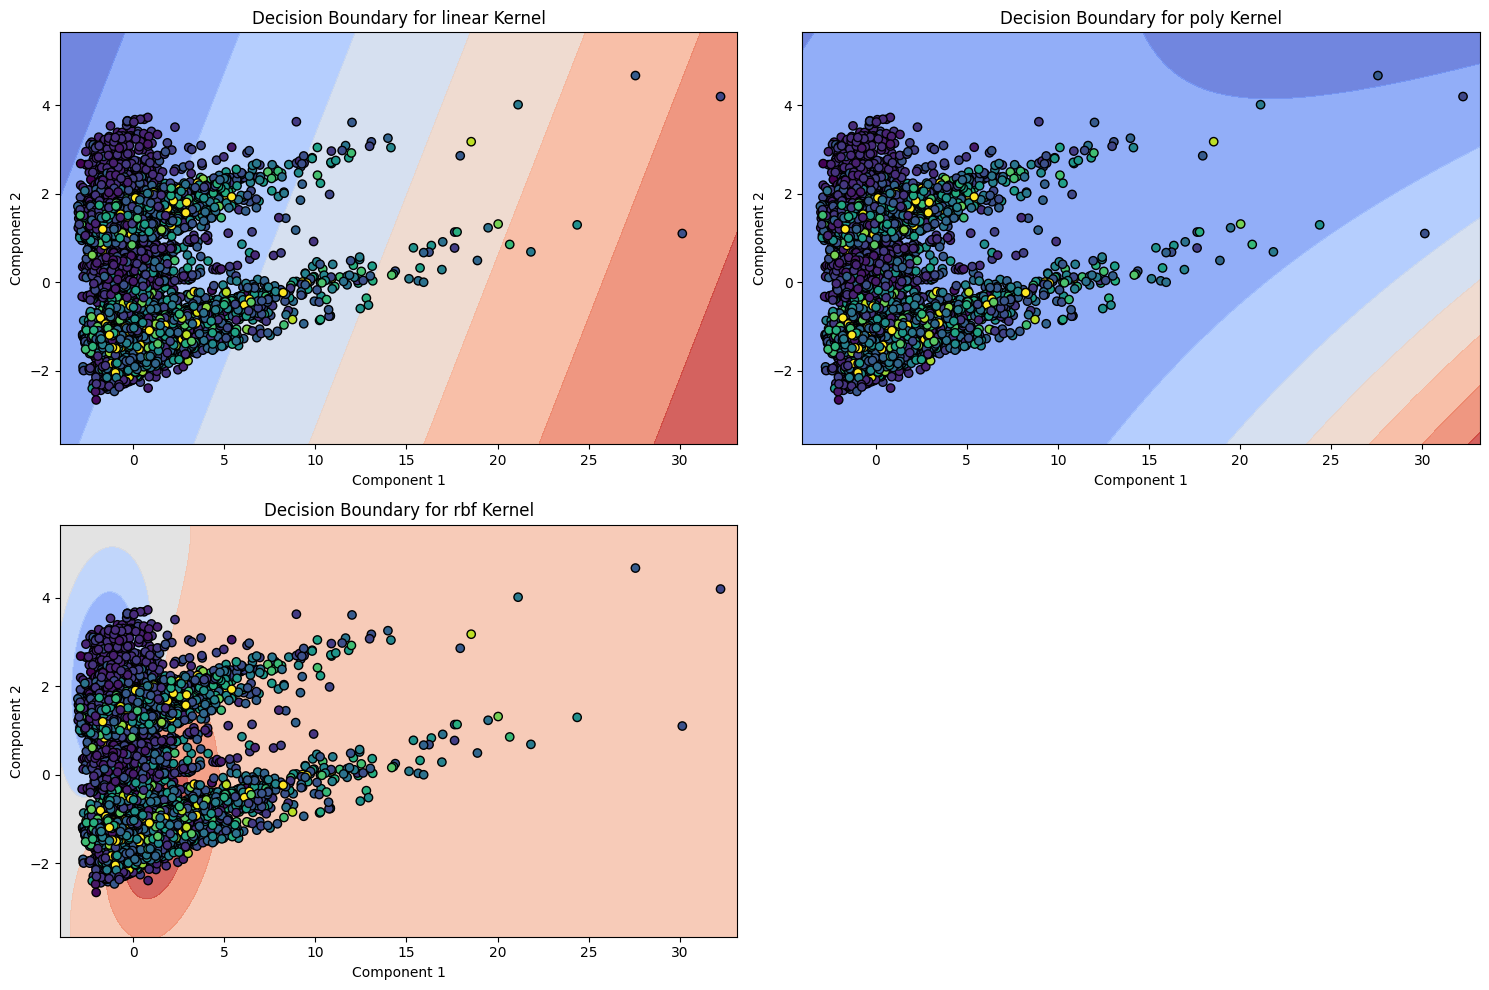

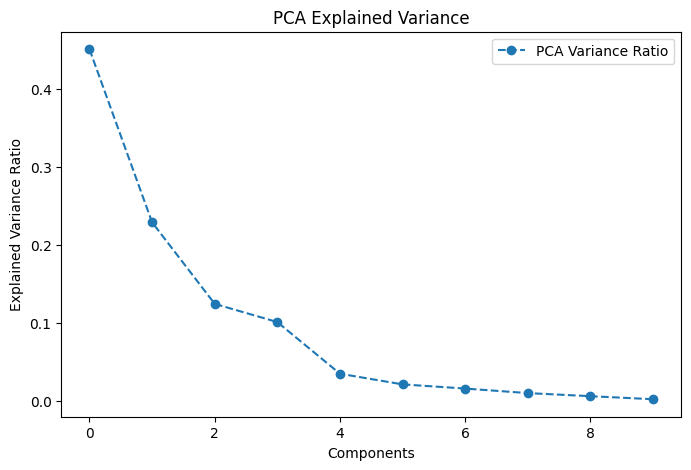

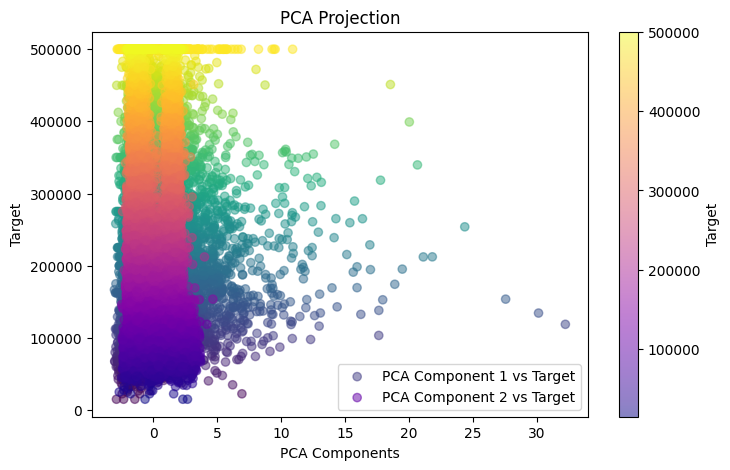

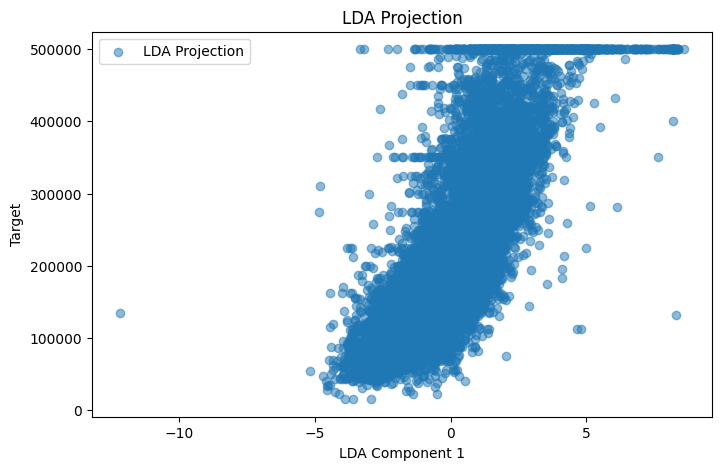

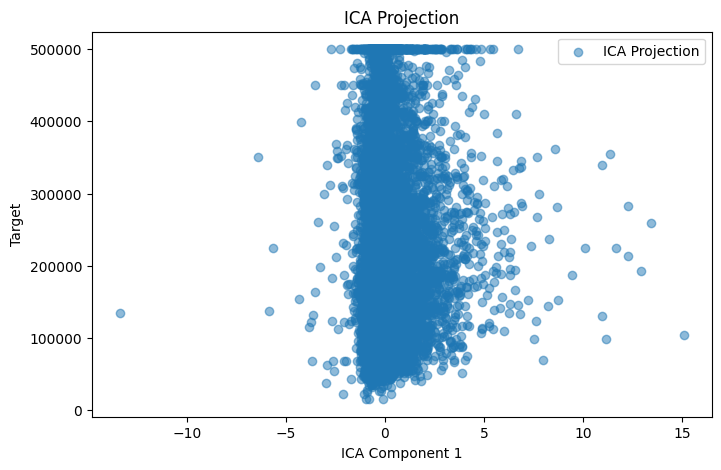

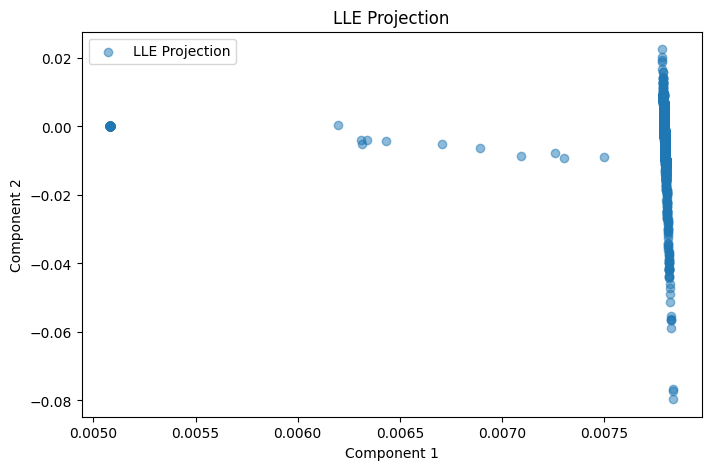

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


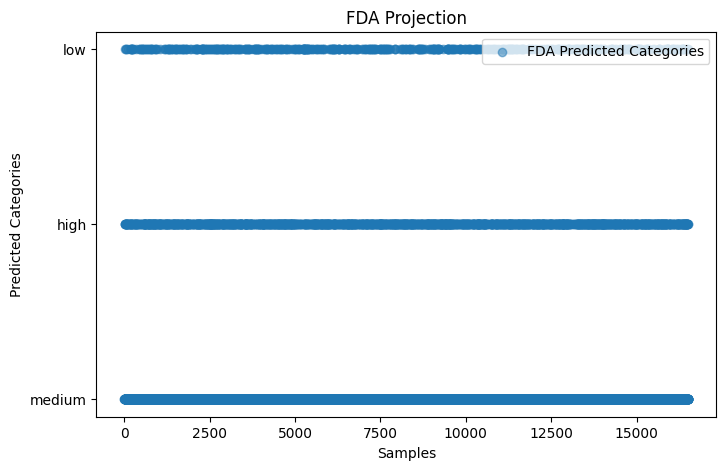

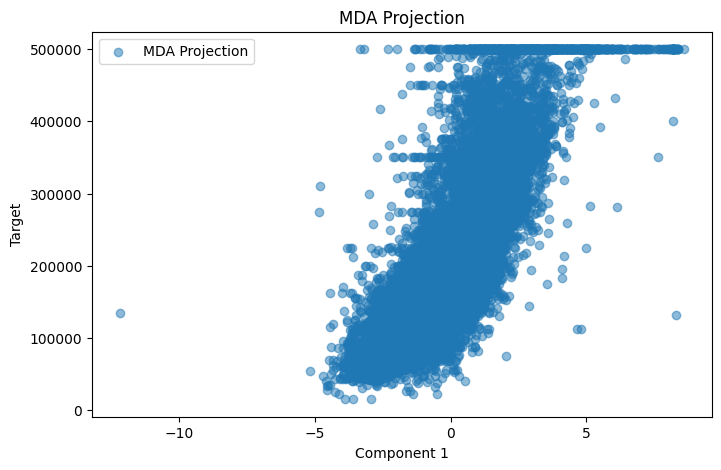

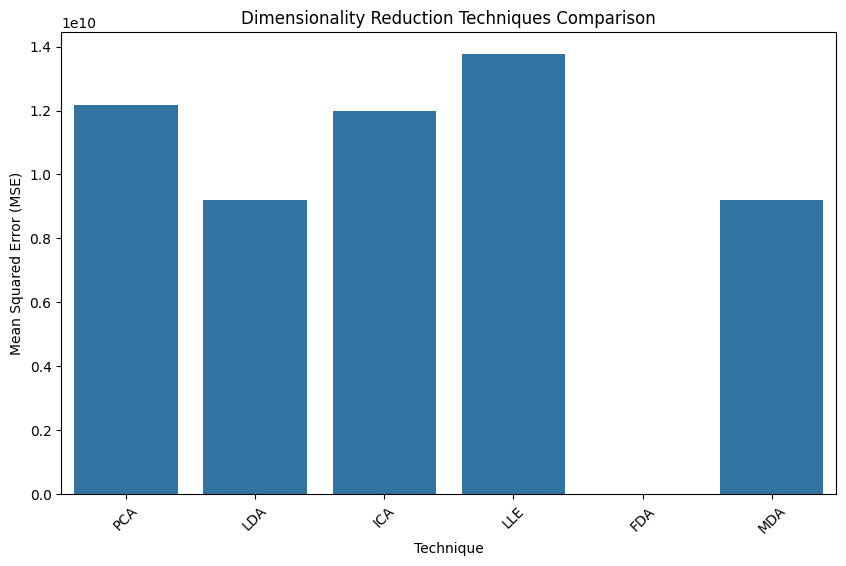


Overall Results: {'PCA': 12161710039.529161, 'LDA': 9199086834.652466, 'ICA': 11970122097.475521, 'LLE': 13761958966.819382, 'FDA': 0.42296511627906974, 'MDA': 9203380919.05142}


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import learning_curve

# Load the dataset
data = pd.read_csv('/content/housing.csv')

# Preprocessing
numerical_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                      'total_bedrooms', 'population', 'households', 'median_income']
categorical_features = ['ocean_proximity']

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Separate features and target
X = data.drop(columns=['median_house_value'])
y = data['median_house_value']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# SVM with different kernels
def evaluate_svm_kernels(X_train, X_test, y_train, y_test, kernels):
    results = {}
    for kernel in kernels:
        model = SVR(kernel=kernel)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results[kernel] = mse
    return results

def plot_heatmap(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame({'Actual': y_true, 'Predicted': y_pred}).corr(), annot=True, cmap='coolwarm')
    plt.title(title)
    plt.show()

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error')
    train_mean = -train_scores.mean(axis=1)
    test_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training Error', marker='o')
    plt.plot(train_sizes, test_mean, label='Validation Error', marker='o')
    plt.title(title)
    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

def plot_decision_boundaries(X, y, kernels):
    X_reduced = PCA(n_components=2).fit_transform(X)
    x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
    y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    plt.figure(figsize=(15, 10))
    for i, kernel in enumerate(kernels):
        model = SVR(kernel=kernel)
        model.fit(X_reduced, y)
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.subplot(2, 2, i + 1)
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', marker='o')
        plt.title(f'Decision Boundary for {kernel} Kernel')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')

    plt.tight_layout()
    plt.show()

kernels = ['linear', 'poly', 'rbf']
svm_kernel_results = evaluate_svm_kernels(X_train_processed, X_test_processed, y_train, y_test, kernels)

# Plot SVM Kernel Results
plt.figure(figsize=(8, 5))
sns.barplot(x=list(svm_kernel_results.keys()), y=list(svm_kernel_results.values()))
plt.title('SVM Kernel Comparison')
plt.xlabel('Kernel')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

# Example SVM Visualizations
model = SVR(kernel='rbf')
model.fit(X_train_processed, y_train)
y_pred = model.predict(X_test_processed)
plot_heatmap(y_test, y_pred, "Heatmap of Predicted vs. Actual Values (RBF Kernel)")
plot_learning_curve(SVR(kernel='poly'), X_train_processed, y_train, "Learning Curve for Polynomial Kernel")
plot_decision_boundaries(X_train_processed, y_train, kernels)

# Function to evaluate SVM performance
def evaluate_svm(X_train, X_test, y_train, y_test):
    model = SVR(kernel='linear')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Dimensionality Reduction Evaluation
results = {}

# 1. PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)
results['PCA'] = evaluate_svm(X_train_pca, X_test_pca, y_train, y_test)

# Plot PCA Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle='--', label='PCA Variance Ratio')
plt.title('PCA Explained Variance')
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.show()

# Scatter plot of the first two PCA components
plt.figure(figsize=(8, 5))
plt.scatter(X_train_pca[:, 0], y_train, alpha=0.5, label='PCA Component 1 vs Target', c=y_train, cmap='viridis')
plt.scatter(X_train_pca[:, 1], y_train, alpha=0.5, label='PCA Component 2 vs Target', c=y_train, cmap='plasma')
plt.title('PCA Projection')
plt.xlabel('PCA Components')
plt.ylabel('Target')
plt.legend()
plt.colorbar(label='Target')
plt.show()


# 2. LDA
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_processed, y_train)
X_test_lda = lda.transform(X_test_processed)
results['LDA'] = evaluate_svm(X_train_lda, X_test_lda, y_train, y_test)

plt.figure(figsize=(8, 5))
plt.scatter(X_train_lda[:, 0], y_train, alpha=0.5, label='LDA Projection')
plt.title('LDA Projection')
plt.xlabel('LDA Component 1')
plt.ylabel('Target')
plt.legend()
plt.show()

# 3. ICA
ica = FastICA(n_components=10, random_state=42)
X_train_ica = ica.fit_transform(X_train_processed)
X_test_ica = ica.transform(X_test_processed)
results['ICA'] = evaluate_svm(X_train_ica, X_test_ica, y_train, y_test)

plt.figure(figsize=(8, 5))
plt.scatter(X_train_ica[:, 0], y_train, alpha=0.5, label='ICA Projection')
plt.title('ICA Projection')
plt.xlabel('ICA Component 1')
plt.ylabel('Target')
plt.legend()
plt.show()

# 4. LLE
lle = LocallyLinearEmbedding(n_components=10, random_state=42)
X_train_lle = lle.fit_transform(X_train_processed)
X_test_lle = lle.transform(X_test_processed)
results['LLE'] = evaluate_svm(X_train_lle, X_test_lle, y_train, y_test)

plt.figure(figsize=(8, 5))
plt.scatter(X_train_lle[:, 0], X_train_lle[:, 1], alpha=0.5, label='LLE Projection')
plt.title('LLE Projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

# 5. FDA
fda = QDA()

# Discretize the target variable into bins (e.g., low, medium, high)
y_binned_train = pd.cut(y_train, bins=3, labels=['low', 'medium', 'high'])
y_binned_test = pd.cut(y_test, bins=3, labels=['low', 'medium', 'high'])

# Train the QDA model on the discretized target
fda.fit(X_train_processed, y_binned_train)

# Predict the categories for both training and test sets
X_train_fda = fda.predict(X_train_processed)
X_test_fda = fda.predict(X_test_processed)

# Calculate the performance of the model (use categorical accuracy or another appropriate metric)
from sklearn.metrics import accuracy_score
results['FDA'] = accuracy_score(y_binned_test, X_test_fda)

# Plot the FDA results (if needed)
plt.figure(figsize=(8, 5))
plt.scatter(range(len(X_train_fda)), X_train_fda, alpha=0.5, label='FDA Predicted Categories')
plt.title('FDA Projection')
plt.xlabel('Samples')
plt.ylabel('Predicted Categories')
plt.legend()
plt.show()

# 6. MDA
mda = LDA(n_components=min(len(np.unique(y_train)) - 1, X_train_processed.shape[1]))
X_train_mda = mda.fit_transform(X_train_processed, y_train)
X_test_mda = mda.transform(X_test_processed)
results['MDA'] = evaluate_svm(X_train_mda, X_test_mda, y_train, y_test)

plt.figure(figsize=(8, 5))
plt.scatter(X_train_mda[:, 0], y_train, alpha=0.5, label='MDA Projection')
plt.title('MDA Projection')
plt.xlabel('Component 1')
plt.ylabel('Target')
plt.legend()
plt.show()

# Comparative Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title('Dimensionality Reduction Techniques Comparison')
plt.xlabel('Technique')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(rotation=45)
plt.show()

# Print overall results
print("\nOverall Results:", results)
